In [1]:
# Project: CrimesDelits
# Creation Date: 2023-10-11
# History:
######################################################################################################################################################
#   DATE            AUTHOR      VERSION     ACTION
#   2023-10-11      LLEG        1.0.0       Creation

import time
import logging
import warnings

from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import geopandas as gpd
from sklearn.metrics import r2_score, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score

from utils.log_config import Logging
from utils.constant import Constant
from utils.functions import download_file, read_xlsx

In [1]:
# load logging config
Logging.create_log_folder()
Logging.load_logging_config("./conf/logging.json")
log = logging.getLogger(__name__)

In [1]:
starting_time = time.time()
log.debug('Start')

In [1]:
download_file(url=Constant.DATA_URL, filepath=Constant.DATA_FILE)
download_file(url=Constant.DOCUMENTATION_URL, filepath=Constant.DOCUMENTATION_FILE)
download_file(url=Constant.INSTRUCTIONS_URL, filepath=Constant.INSTRUCTIONS_FILE)
download_file(url=Constant.GEOJSON_URL, filepath=Constant.GEOJSON_FILE)

[INFO] 2023-11-30 01:32:59,679 utils.functions.download_file() 34: crimes-delits.xlsx file already exists
[INFO] 2023-11-30 01:32:59,680 utils.functions.download_file() 34: documentation.docx file already exists
[INFO] 2023-11-30 01:32:59,681 utils.functions.download_file() 34: instructions.pdf file already exists
[INFO] 2023-11-30 01:32:59,681 utils.functions.download_file() 34: contour-des-departements.geojson file already exists


In [1]:
dict_df = read_xlsx(Constant.DATA_FILE)

In [1]:
# check for Na
na_sum = 0
for key in dict_df.keys():
    na_sum += dict_df[key].loc[Constant.CHOSEN_INDEX, :].sum().isna().sum()

print(f"NaN sum for {Constant.CHOSEN_INDEX}: {na_sum}")

NaN sum for [29, 30]: 0


In [1]:
# create dataframe with groupby on departements and selecting chosen crime
df = pd.DataFrame({key: value.T.groupby(level='Départements').sum().T.loc[Constant.CHOSEN_INDEX].sum() for key, value in dict_df.items()}).T
df.columns.name = None
df.fillna(0, inplace=True)

df.insert(0, 'year', np.int_)
df.insert(1, 'services', np.int_)
df.insert(2, 'total', np.int_)

for index, row in df.iterrows():
    df.loc[index, 'year'] = index[-4:]
    df.loc[index, 'services'] = index[9:11]
    df.loc[index, 'total'] = row.drop(['year', 'services', 'total']).sum()
    
df.sort_values('year', inplace=True)
df.reset_index(inplace=True, drop=True)

df

,year,services,total,01,02,03,04,05,06,07,...,95,971,972,973,974,976,978,986,987,988
0,2012,PN,66839.0,250.0,385.0,297.0,196.0,112.0,2120.0,127.0,...,1217.0,230.0,157.0,155.0,587.0,290.0,0.0,0.0,101.0,249.0
1,2012,GN,54201.0,892.0,693.0,212.0,236.0,143.0,417.0,453.0,...,249.0,529.0,365.0,349.0,479.0,0.0,160.0,5.0,259.0,219.0
2,2013,GN,59292.0,989.0,675.0,304.0,234.0,185.0,383.0,463.0,...,246.0,631.0,403.0,496.0,502.0,0.0,166.0,4.0,297.0,289.0
3,2013,PN,70917.0,298.0,389.0,278.0,115.0,135.0,1842.0,161.0,...,1045.0,376.0,236.0,163.0,554.0,324.0,0.0,0.0,101.0,314.0
4,2014,GN,59622.0,993.0,678.0,285.0,218.0,214.0,375.0,530.0,...,354.0,589.0,307.0,501.0,436.0,0.0,129.0,6.0,257.0,295.0
5,2014,PN,79142.0,261.0,386.0,234.0,96.0,189.0,1957.0,207.0,...,1202.0,295.0,243.0,110.0,547.0,351.0,0.0,0.0,128.0,224.0
6,2015,GN,59293.0,1262.0,587.0,276.0,219.0,122.0,426.0,484.0,...,325.0,462.0,371.0,464.0,629.0,0.0,201.0,9.0,249.0,365.0
7,2015,PN,82681.0,252.0,345.0,306.0,138.0,236.0,1667.0,161.0,...,1356.0,356.0,273.0,198.0,632.0,323.0,0.0,0.0,131.0,471.0
8,2016,PN,80636.0,298.0,350.0,292.0,140.0,215.0,1693.0,77.0,...,1333.0,381.0,258.0,176.0,612.0,265.0,0.0,0.0,98.0,462.0
9,2016,GN,56709.0,1206.0,631.0,278.0,247.0,174.0,402.0,438.0,...,298.0,478.0,251.0,486.0,516.0,0.0,82.0,5.0,265.0,402.0


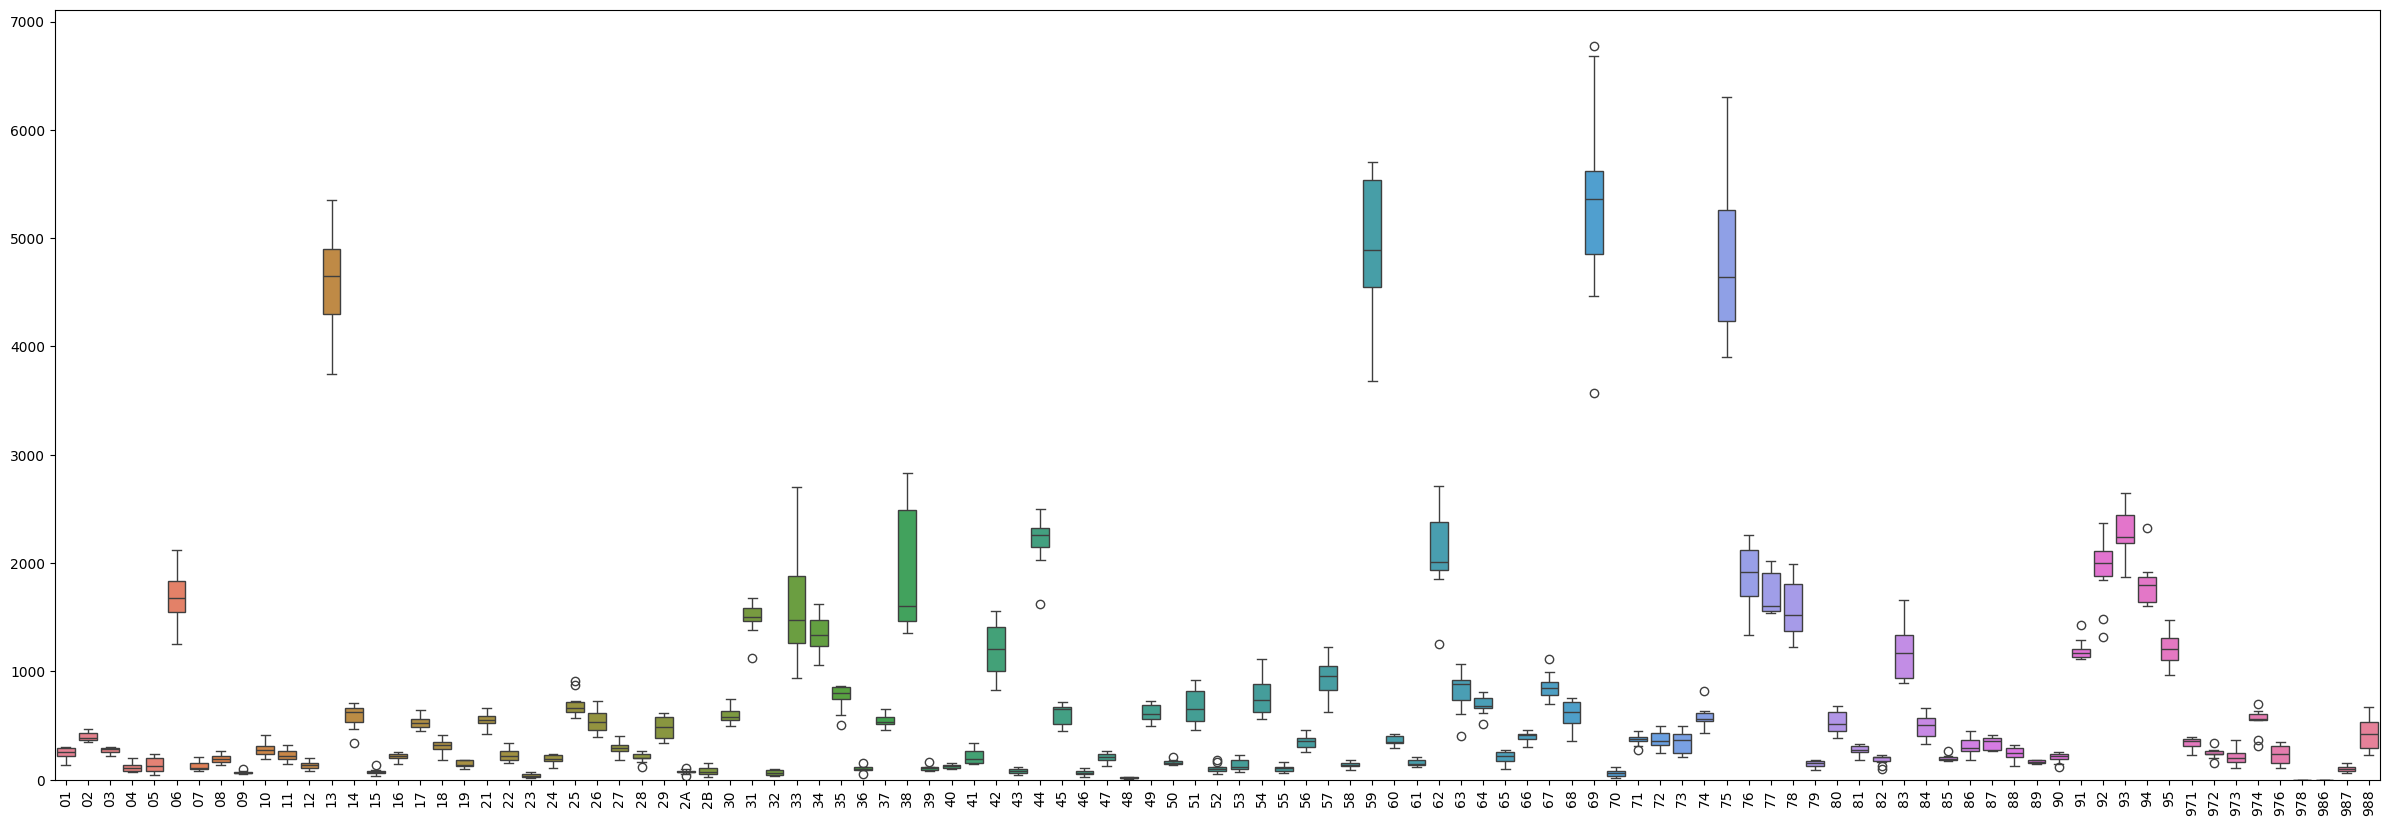

In [1]:
# plot boxplots of chosen service and crime
_, ax = plt.subplots(figsize=(30, 10))
sns.boxplot(data=df.drop(['year', 'total'], axis=1)[df['services'] == Constant.SERVICE])
plt.xticks(rotation=90)
ax.set(ylim=(0))
plt.show()

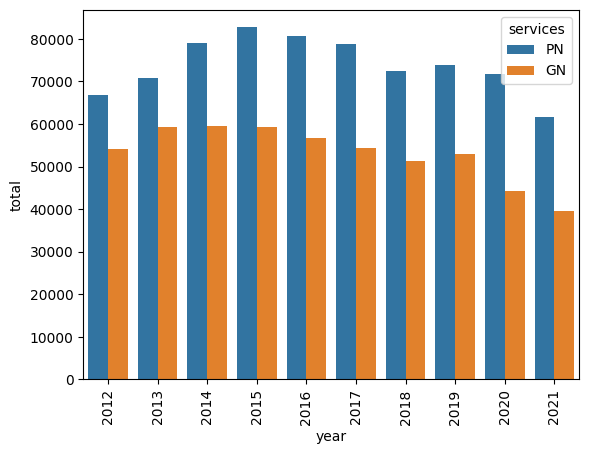

In [1]:
# plot total of index of choice by year
sns.barplot(data=df, x="year", y="total", hue="services", order=sorted(df["year"]))
plt.xticks(rotation=90)
plt.show()

In [1]:
# Read file with geopandas
geo_df = gpd.read_file(Constant.GEOJSON_FILE)

# Plot PN 2012 heatmap
geo_df['Services PN 2012'] = np.int_
for index, row in geo_df.iterrows():
    geo_df.loc[index, 'Services PN 2012'] = round(df[(df['services'] == Constant.SERVICE) & (df['year'] == '2012')][row['code']].iloc[0] / df.drop(['year', 'services', 'total'], axis=1)[(df['services'] == Constant.SERVICE) & (df['year'] == '2012')].max().max(), 3)

<Axes: >

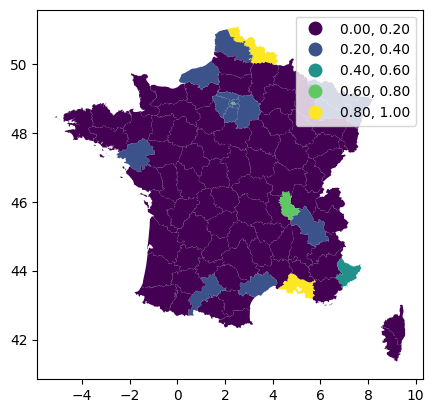

In [1]:
geo_df.plot(column='Services PN 2012', legend=True, scheme="prettybreaks")

In [1]:
df.rename(columns={'year': 'ds', 'total': 'y'}, inplace=True)

In [1]:
df_PN = df[df['services'] == Constant.SERVICE]

In [1]:
df_PN.index = pd.DatetimeIndex(df_PN.ds)
df_PN = df_PN.drop('ds', axis=1)

In [1]:
df_train = df_PN[df_PN.index < Constant.TRAIN_TEST_SPLIT_YEAR]
df_test = df_PN[df_PN.index >= Constant.TRAIN_TEST_SPLIT_YEAR]

In [1]:
warnings.filterwarnings("ignore")

[INFO] 2023-11-30 01:33:05,506 __main__.<module>() 53: ARIMA RMSE: 8178.818642622079, ARIMA R²: -1.598757926904676
[INFO] 2023-11-30 01:33:05,506 __main__.<module>() 54: SMA RMSE: 8800.558355101868, SMA R²: -2.0088817808413735
[INFO] 2023-11-30 01:33:05,507 __main__.<module>() 55: EMA RMSE: 7559.922150991449, EMA R²: -1.2203391529769574
[INFO] 2023-11-30 01:33:05,507 __main__.<module>() 56: MLP RMSE: 1624.031017396493, MLP R²: 0.8975355272287601


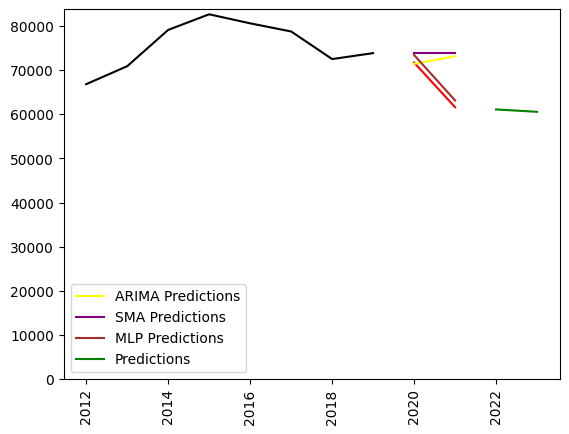

In [1]:
# plot existing data
plt.plot(df_train.index, df_train['y'], color="black")
plt.plot(df_test.index, df_test['y'], color="red")
plt.xticks(rotation=90)

y = df_train['y'].astype(int)
arima_model = ARIMA(y, order = (3, 2, 2))
arima_model = arima_model.fit()

# ARIMA Predictions
y_pred_arima = arima_model.get_forecast(len(df_test.index))
y_pred_df_arima = y_pred_arima.conf_int(alpha = 0.05) 
y_pred_df_arima["Predictions"] = arima_model.predict(start = y_pred_df_arima.index[0], end = y_pred_df_arima.index[-1])

# Simple Moving Average (SMA)
sma_model = SimpleExpSmoothing(df_train['y'].astype(int)).fit()
y_pred_sma = sma_model.forecast(len(df_test))

# Exponential Moving Average (EMA)
ema_model = ExponentialSmoothing(df_train['y'].astype(int), trend='add', damped_trend=True).fit()
y_pred_ema = ema_model.forecast(len(df_test))

# MLPRegressor
mlp_model = MLPRegressor(hidden_layer_sizes=(100,), max_iter=1000)
mlp_model.fit(df_train.drop(['services'], axis=1), df_PN.loc['2013': Constant.TRAIN_TEST_SPLIT_YEAR, 'y'])
y_pred_mlp = mlp_model.predict(df_test.drop(['services'], axis=1))

# plot predictions
plt.plot(df_test.index, y_pred_df_arima["Predictions"] , color='Yellow', label='ARIMA Predictions')
plt.plot(df_test.index, y_pred_sma, color='purple', label='SMA Predictions')
plt.plot(df_test.index, y_pred_mlp, color='brown', label='MLP Predictions')

ema_model = ExponentialSmoothing(df_PN['y'].astype(int), trend='add', damped_trend=True).fit()
y_pred_ema = ema_model.forecast(2)
plt.plot(pd.date_range('2022', freq='AS', periods=2), y_pred_ema, color='green', label='Predictions')

plt.legend()
plt.ylim(0,)

# metrics
arma_rmse = np.sqrt(mean_squared_error(df_test["y"].values, y_pred_df_arima["Predictions"]))
r2_arma = r2_score(df_test["y"].values, y_pred_df_arima["Predictions"])

sma_rmse = np.sqrt(mean_squared_error(df_test["y"].values, y_pred_sma))
r2_sma = r2_score(df_test["y"].values, y_pred_sma)

ema_rmse = np.sqrt(mean_squared_error(df_test["y"].values, y_pred_ema))
r2_ema = r2_score(df_test["y"].values, y_pred_ema)

mlp_rmse = np.sqrt(mean_squared_error(df_test["y"].values, y_pred_mlp))
r2_mlp = r2_score(df_test["y"].values, y_pred_mlp)

log.info("ARIMA RMSE: %s, ARIMA R²: %s", arma_rmse, r2_arma)
log.info("SMA RMSE: %s, SMA R²: %s", sma_rmse, r2_sma)
log.info("EMA RMSE: %s, EMA R²: %s", ema_rmse, r2_ema)
log.info("MLP RMSE: %s, MLP R²: %s", mlp_rmse, r2_mlp)

In [1]:
# Cross validation for MLP Model
X = df_train.drop(['services', 'y'], axis=1)
y = df_train['y']

scorer = make_scorer(r2_score)
cv_scores = cross_val_score(mlp_model, X, y, cv=3, scoring=scorer)

log.info("Scores de Validation Croisée: %s", cv_scores)
log.info("RMSE Moyen: %s", np.mean(cv_scores))

[INFO] 2023-11-30 01:33:05,667 __main__.<module>() 8: Scores de Validation Croisée: [0.99660638 0.69963203 0.87262088]
[INFO] 2023-11-30 01:33:05,668 __main__.<module>() 9: RMSE Moyen: 0.8562864275451822


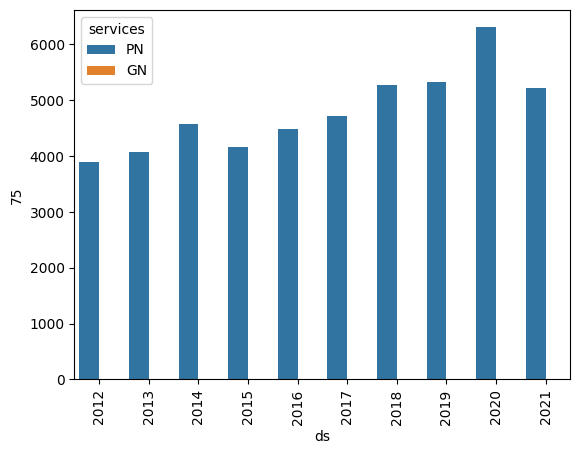

In [1]:
# Paris crime evolution
sns.barplot(data=df, x="ds", y="75", hue="services", order=sorted(df["ds"]))
plt.xticks(rotation=90)
plt.show()

In [1]:
arma_rmse, r2_arma = 0, 0
sma_rmse, r2_sma = 0, 0
ema_rmse, r2_ema = 0, 0
mlp_rmse, r2_mlp = 0, 0
for dept in tqdm(df_train.drop(['services', 'y'], axis=1).columns) :
    y = df_train[dept].astype(int)
    arima_model = ARIMA(y, order = (1, 2, 2))
    arima_model = arima_model.fit()

    # ARIMA Predictions
    y_pred_arima = arima_model.get_forecast(len(df_test.index))
    y_pred_df_arima = y_pred_arima.conf_int(alpha = 0.05) 
    y_pred_df_arima["Predictions"] = arima_model.predict(start = y_pred_df_arima.index[0], end = y_pred_df_arima.index[-1])

    # Simple Moving Average (SMA)
    sma_model = SimpleExpSmoothing(df_train[dept].astype(int)).fit()
    y_pred_sma = sma_model.forecast(len(df_test))

    # Exponential Moving Average (EMA)
    ema_model = ExponentialSmoothing(df_train[dept].astype(int)).fit()
    y_pred_ema = ema_model.forecast(len(df_test))

    # MLPRegressor
    mlp_model = MLPRegressor(hidden_layer_sizes=(100,), max_iter=1000)
    mlp_model.fit(df_train.drop(['services'], axis=1), df_train['y'])
    y_pred_mlp = mlp_model.predict(df_test.drop(['services'], axis=1))

    # metrics
    arma_rmse += np.sqrt(mean_squared_error(df_test[dept].values, y_pred_df_arima["Predictions"]))
    r2_arma += r2_score(df_test["y"].values, y_pred_df_arima["Predictions"])

    sma_rmse += np.sqrt(mean_squared_error(df_test[dept].values, y_pred_sma))
    r2_sma += r2_score(df_test["y"].values, y_pred_sma)

    ema_rmse += np.sqrt(mean_squared_error(df_test[dept].values, y_pred_ema))
    r2_ema += r2_score(df_test["y"].values, y_pred_ema)

    mlp_rmse += np.sqrt(mean_squared_error(df_test[dept].values, y_pred_mlp))
    r2_mlp += r2_score(df_test["y"].values, y_pred_mlp)

log.info("ARIMA RMSE: %s, ARIMA R²: %s", arma_rmse / len(df_train.drop(['services', 'y'], axis=1).columns), r2_arma / len(df_train.drop(['services', 'y'], axis=1).columns))
log.info("SMA RMSE: %s, SMA R²: %s", sma_rmse / len(df_train.drop(['services', 'y'], axis=1).columns), r2_sma / len(df_train.drop(['services', 'y'], axis=1).columns))
log.info("EMA RMSE: %s, EMA R²: %s", ema_rmse / len(df_train.drop(['services', 'y'], axis=1).columns), r2_ema / len(df_train.drop(['services', 'y'], axis=1).columns))
log.info("MLP RMSE: %s, MLP R²: %s", mlp_rmse / len(df_train.drop(['services', 'y'], axis=1).columns), r2_mlp / len(df_train.drop(['services', 'y'], axis=1).columns))

100%|██████████| 105/105 [00:07<00:00, 14.50it/s]
--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\lolo\AppData\Local\Programs\Python\Python312\Lib\logging\__init__.py", line 1160, in emit
    msg = self.format(record)
          ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\lolo\AppData\Local\Programs\Python\Python312\Lib\logging\__init__.py", line 999, in format
    return fmt.format(record)
           ^^^^^^^^^^^^^^^^^^
  File "c:\Users\lolo\AppData\Local\Programs\Python\Python312\Lib\logging\__init__.py", line 703, in format
    record.message = record.getMessage()
                     ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\lolo\AppData\Local\Programs\Python\Python312\Lib\logging\__init__.py", line 392, in getMessage
    msg = msg % self.args
          ~~~~^~~~~~~~~~~
TypeError: not all arguments converted during string formatting
Call stack:
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "d:\Dev\Python\c

In [1]:
log.debug('End')
log.info('Finished successfully in %.2fs', time.time() - starting_time)

[INFO] 2023-11-30 01:33:13,021 __main__.<module>() 2: Finished successfully in 13.35s
